<a href="https://colab.research.google.com/github/marinebon/HackingLimno2025/blob/main/03_sdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Modify this section as needed.

# ==============================================================================
# === directory setup
# ==============================================================================
# If using google colab and google drive:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/GSoC_SDM_Project'

# === if using local machine
# PROJECT_DIR = './'
#import os
#if not os.path.exists(PROJECT_DIR):
#    os.makedirs(PROJECT_DIR)

# ==============================================================================
# ==============================================================================
# === spatial coverage
# ==============================================================================
LATMIN = 24.11637699635014
LATMAX = 26.11949526731449
LONMIN = -82.51572158798965
LONMAX = -79.61106009492724
# ==============================================================================

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# install dependencies TODO: are all these needed?
!pip install  rasterio pandas geopandas matplotlib  requests xarray netCDF4

Import libraries & setup


In [23]:
# TODO: are all these imports needed?


# Standard library imports
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Union
import warnings

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import xarray as xr
from scipy.spatial.distance import cdist
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline


SDM Class for Marine species


In [24]:
class MarineSpeciesDistributionModel:
    """
    A Species Distribution Model for marine species using One-Class SVM
    Similar to the scikit-learn species distribution example but adapted for marine data
    """

    def __init__(self, nu=0.1, kernel='rbf', gamma=0.5):
        """
        Initialize the SDM model

        Parameters:
        -----------
        nu : float, default=0.1
            An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors
        kernel : str, default='rbf'
            Kernel type for SVM
        gamma : float, default=0.5
            Kernel coefficient for 'rbf'
        """
        self.nu = nu
        self.kernel = kernel
        self.gamma = gamma
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.species_name = None

    def add_environmental_data(self, df, raster_path, column_name='environmental_var',
                              lat_col='decimalLatitude', lon_col='decimalLongitude'):
        """
        Add environmental data from raster to occurrence dataframe
        """
        df_result = df.copy()

        try:
            with rasterio.open(raster_path) as src:
                coords = [(row[lon_col], row[lat_col]) for _, row in df.iterrows()]
                sampled_values = list(src.sample(coords))
                values = [val[0] if val[0] != src.nodata else np.nan for val in sampled_values]
                df_result[column_name] = values

            valid_count = df_result[column_name].notna().sum()
            print(f"Added {column_name}: {valid_count}/{len(df_result)} valid values")

        except Exception as e:
            print(f"Error adding environmental data from {raster_path}: {e}")
            df_result[column_name] = np.nan

        return df_result

    def prepare_data(self, df, environmental_cols, lat_col='decimalLatitude',
                    lon_col='decimalLongitude', test_size=0.2, random_state=42):
        """
        Prepare training and testing data from occurrence dataframe
        """
        df_clean = df.dropna(subset=environmental_cols)

        if len(df_clean) == 0:
            raise ValueError("No valid data points after removing missing values")


        coords = df_clean[[lat_col, lon_col]].values
        env_features = df_clean[environmental_cols].values


        X_train, X_test, coords_train, coords_test = train_test_split(
            env_features, coords, test_size=test_size, random_state=random_state
        )

        self.feature_names = environmental_cols

        return {
            'X_train': X_train,
            'X_test': X_test,
            'coords_train': coords_train,
            'coords_test': coords_test,
            'df_clean': df_clean
        }

    def fit(self, X_train):
        """
        Fit the One-Class SVM model
        """

        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)


        print("Fitting One-Class SVM...")
        self.model = svm.OneClassSVM(nu=self.nu, kernel=self.kernel, gamma=self.gamma)
        self.model.fit(X_train_scaled)
        print("Model fitting completed.")

    def predict(self, X):
        """
        Predict species suitability for given environmental conditions
        """
        if self.model is None or self.scaler is None:
            raise ValueError("Model must be fitted before prediction")

        X_scaled = self.scaler.transform(X)
        return self.model.decision_function(X_scaled)

    def create_prediction_grid(self, raster_paths, grid_resolution=0.1,
                              bounds=None, column_names=None):
        """
        Create a prediction grid from environmental rasters

        Parameters:
        -----------
        raster_paths : list
            List of paths to environmental raster files
        grid_resolution : float
            Resolution of the prediction grid in degrees
        bounds : tuple
            (min_lon, min_lat, max_lon, max_lat) bounds for the grid
        column_names : list
            Names for the environmental variables
        """
        if column_names is None:
            column_names = [f'env_var_{i}' for i in range(len(raster_paths))]


        if bounds is None:
            with rasterio.open(raster_paths[0]) as src:
                bounds = src.bounds
                bounds = (bounds.left, bounds.bottom, bounds.right, bounds.top)

        min_lon, min_lat, max_lon, max_lat = bounds


        lons = np.arange(min_lon, max_lon, grid_resolution)
        lats = np.arange(min_lat, max_lat, grid_resolution)
        lon_grid, lat_grid = np.meshgrid(lons, lats)


        coords_flat = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])


        env_data = []
        for i, raster_path in enumerate(raster_paths):
            try:
                with rasterio.open(raster_path) as src:
                    sampled_values = list(src.sample(coords_flat))
                    values = [val[0] if val[0] != src.nodata else np.nan for val in sampled_values]
                    env_data.append(values)
                    print(f"Sampled {column_names[i]}: {sum(~np.isnan(values))}/{len(values)} valid values")
            except Exception as e:
                print(f"Error sampling from {raster_path}: {e}")
                env_data.append([np.nan] * len(coords_flat))


        grid_df = pd.DataFrame({
            'longitude': coords_flat[:, 0],
            'latitude': coords_flat[:, 1]
        })

        for i, col_name in enumerate(column_names):
            grid_df[col_name] = env_data[i]


        grid_df_clean = grid_df.dropna()

        return grid_df_clean, (lons, lats)

    def evaluate_model(self, X_test, background_points_env=None, n_background=1000):
        """
        Evaluate model performance using AUC
        """

        pred_test = self.predict(X_test)

        if background_points_env is None:
            feature_mins = np.min(np.vstack([X_test, self.scaler.transform(X_test)]), axis=0)
            feature_maxs = np.max(np.vstack([X_test, self.scaler.transform(X_test)]), axis=0)

            background_points_env = np.random.uniform(
                low=feature_mins, high=feature_maxs,
                size=(n_background, X_test.shape[1])
            )

        pred_background = self.predict(background_points_env)

        scores = np.concatenate([pred_test, pred_background])
        y_true = np.concatenate([np.ones(len(pred_test)), np.zeros(len(pred_background))])


        fpr, tpr, thresholds = metrics.roc_curve(y_true, scores)
        auc_score = metrics.auc(fpr, tpr)

        return auc_score, fpr, tpr

    def plot_distribution_map(self, grid_df, prediction_col='suitability',
                             occurrence_data=None, figsize=(12, 8)):
        """
        Plot the species distribution map
        """
        plt.figure(figsize=figsize)


        scatter = plt.scatter(grid_df['longitude'], grid_df['latitude'],
                            c=grid_df[prediction_col], cmap='Reds',
                            s=1, alpha=0.6)
        plt.colorbar(scatter, label='Habitat Suitability')

        if occurrence_data is not None:
            if 'coords_train' in occurrence_data:
                plt.scatter(occurrence_data['coords_train'][:, 1],
                          occurrence_data['coords_train'][:, 0],
                          c='black', marker='^', s=20, label='Training', alpha=0.8)

            if 'coords_test' in occurrence_data:
                plt.scatter(occurrence_data['coords_test'][:, 1],
                          occurrence_data['coords_test'][:, 0],
                          c='blue', marker='x', s=20, label='Testing', alpha=0.8)

            plt.legend()

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Species Distribution Model: {self.species_name or "Unknown Species"}')
        plt.grid(True, alpha=0.3)

        return plt.gcf()


Fitting One-Class SVM...
Model fitting completed.
Model AUC Score: 0.967

 Creating visualizations...


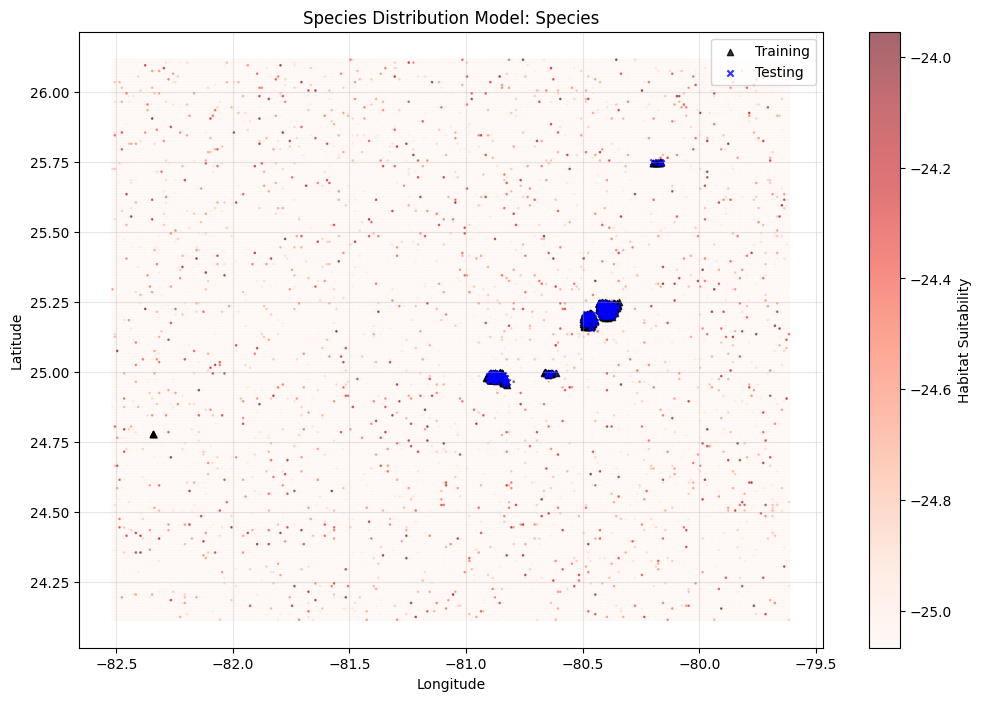

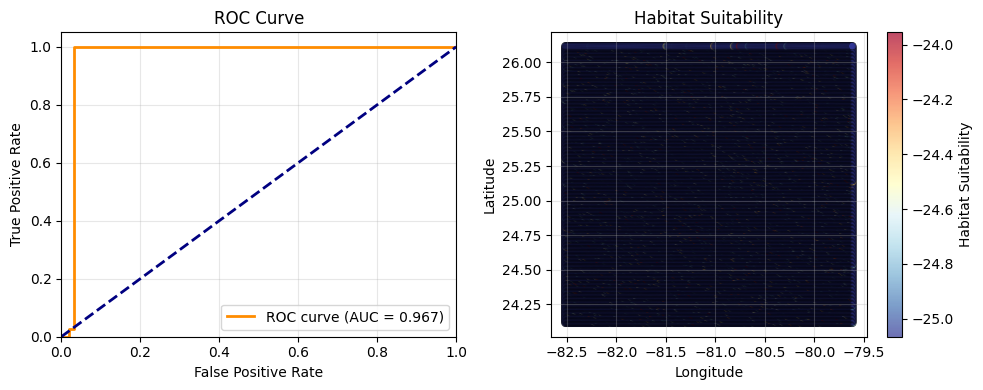

In [28]:
df = pd.read_parquet(f'{PROJECT_DIR}/occurrences_and_environment.parquet')
environmental_cols = ['temperature']#, 'temperature_sd']  # TODO: can we get these dynamically from the df?

# Initialize  SDM
sdm = MarineSpeciesDistributionModel(nu=0.1, kernel='rbf', gamma=0.5)
sdm.species_name = 'Species'

# Prepare the data
data = sdm.prepare_data(df, environmental_cols)

# Fit the model
sdm.fit(data['X_train'])

# Evaluate the model
auc_score, fpr, tpr = sdm.evaluate_model(data['X_test'])
print(f"Model AUC Score: {auc_score:.3f}")

# TODO: fix grid to use LATMIN LONMAX etc

# Create prediction grid
grid_resolution = 0.01
bounds = (LONMIN, LATMIN, LONMAX, LATMAX)

# Create a simple prediction grid
lons = np.arange(bounds[0], bounds[2], grid_resolution)
lats = np.arange(bounds[1], bounds[3], grid_resolution)
lon_grid, lat_grid = np.meshgrid(lons, lats)

grid_coords = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])

# Simulate environmental data for grid
#grid_salinity = np.random.uniform(32, 36, len(grid_coords))
grid_temperature = np.random.uniform(10, 25, len(grid_coords))

grid_env = np.column_stack([grid_temperature])  #[grid_salinity, grid_temperature])

# Make predictions
predictions = sdm.predict(grid_env)

# Create grid DataFrame
grid_df = pd.DataFrame({
    'longitude': grid_coords[:, 0],
    'latitude': grid_coords[:, 1],
#    'salinity': grid_salinity,
    'temperature': grid_temperature,
    'suitability': predictions
})

# Plot the results
fig = sdm.plot_distribution_map(grid_df, occurrence_data=data)



df_results = grid_df

print("\n Creating visualizations...")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
scatter = plt.scatter(
    df_results['longitude'],
    df_results['latitude'],
    c=df_results['suitability'],
    cmap='RdYlBu_r',
    s=30,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, label='Habitat Suitability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Habitat Suitability')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

